# Warp a disk

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np

import diskwarp
from diskwarp import helper

%matplotlib widget
%config InlineBackend.figure_format = 'retina'

## General Definitions of disk surface and warp parameters

Calculate the interfaces and cell centers of the disk surface

In [2]:
r_i = np.linspace(0.1, 150, 201)
r_c = 0.5 * (r_i[1:] + r_i[:-1])

In [3]:
surf     = helper.get_surface(r_i)
p0_i     = surf['points_i']
p0_c     = surf['points_c']
ri       = surf['ri']
rc       = surf['rc']
phic     = surf['phic']
phii     = surf['phii']
nr, nphi = p0_c.shape[:-1]

Define the warp (inclination for each ring): logistic function from $i=0$ outside transitioning to `warp_max` at radius `r0` over a transition width of `dr`.

In [4]:
r0 = 50
dr = 5
tilt = 30
twist = 60

warp_c = helper.warp(r_c, i_in=tilt, r0=r0, dr=dr)
warp_i = helper.warp(r_i, i_in=tilt, r0=r0, dr=dr)

Define each radius' twist

In [5]:
twist_i = helper.twist(r_i, phi=twist, r0=r0, dr=dr) # + np.deg2rad(200.0)
twist_c = helper.twist(r_c, phi=twist, r0=r0, dr=dr) # + np.deg2rad(200.0)

Calculate the velocities of all centers and edges

In [6]:
G = 0
Mstar = 0

v0_c = (p0_c[:, :, 0]**2 + p0_c[:, :, 1]**2)**-0.25
v0_c = v0_c[None, :, :] * np.array([-np.sin(phic), np.cos(phic), np.zeros_like(phic)])
v0_c = np.moveaxis(v0_c, 0, 2)

v0_i = (p0_i[:, :, 0]**2 + p0_i[:, :, 1]**2)**-0.25
v0_i = v0_i[None, :, :] * np.array([-np.sin(phii), np.cos(phii), np.zeros_like(phii)])
v0_i = np.moveaxis(v0_i, 0, 2)

define the inclination of the observer as rotation around x

In [37]:
inc_obs = np.deg2rad(45.0)
PA_obs  = np.deg2rad(45.0)
azi     = np.deg2rad(0.0)

## Apply the warp/twist

In [38]:
p1_c = diskwarp.fmodule.apply_matrix2d(p0_c, warp_c, twist_c, inc_obs, PA_obs, azi)
v1_c = diskwarp.fmodule.apply_matrix2d(v0_c, warp_c, twist_c, inc_obs, PA_obs, azi)
p1_i = diskwarp.fmodule.apply_matrix2d(p0_i, warp_i, twist_i, inc_obs, PA_obs, azi)
v1_i = diskwarp.fmodule.apply_matrix2d(v0_i, warp_i, twist_i, inc_obs, PA_obs, azi)

Text(0.5, 0, 'z')

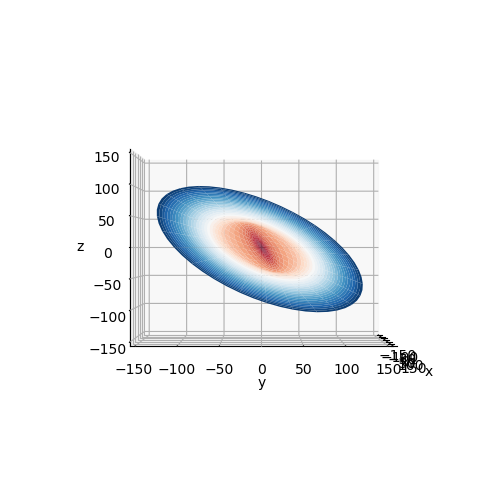

In [39]:
X, Y, Z = p1_i.T

C = Normalize()(ri[:, :].T)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.view_init(0, 0)
surf = ax.plot_surface(X, Y, Z, facecolors=plt.cm.RdBu(C), shade=False, linewidth=0)
ax.set_xlim(-r_i[-1], r_i[-1])
ax.set_ylim(-r_i[-1], r_i[-1])
ax.set_zlim(-r_i[-1], r_i[-1])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

## Now interpolate on sky plane

In [40]:
_gx = np.linspace(-r_i[-1], r_i[-1], 200)
_gy = np.linspace(-r_i[-1], r_i[-1], 210)
img_xi, img_yi = np.meshgrid(_gx, _gy, indexing='ij')
img_xc = 0.5 * (img_xi[1:, 1:] + img_xi[:-1, 1:])
img_yc = 0.5 * (img_yi[1:, 1:] + img_yi[1:, :-1])

In [41]:
X, Y, Z = p1_i.T
vxi, vyi, vzi = v1_i.T
img_z, img_v = diskwarp.fmodule.interpolate_grid(X, Y, Z, vzi, img_xc, img_yc)
_,     img_r = diskwarp.fmodule.interpolate_grid(X, Y, Z, ri.T, img_xc, img_yc)

Get rid of the values outside of the domain

In [42]:
img_v[img_v==img_v[0,0]] = np.nan
img_r[img_r==img_r[0,0]] = np.nan

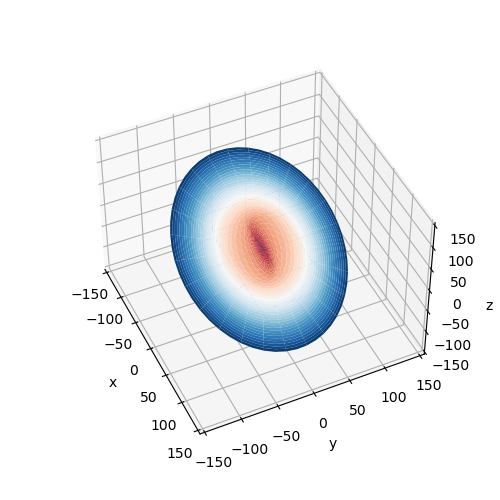

In [43]:
C = Normalize(vmin=0, vmax=150)(rc)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X, Y, Z, facecolors=plt.cm.RdBu(C.T), linewidth=0, shade=False)
ax.set_xlim(-r_i[-1], r_i[-1])
ax.set_ylim(-r_i[-1], r_i[-1])
ax.set_zlim(-r_i[-1], r_i[-1])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(45, -25)

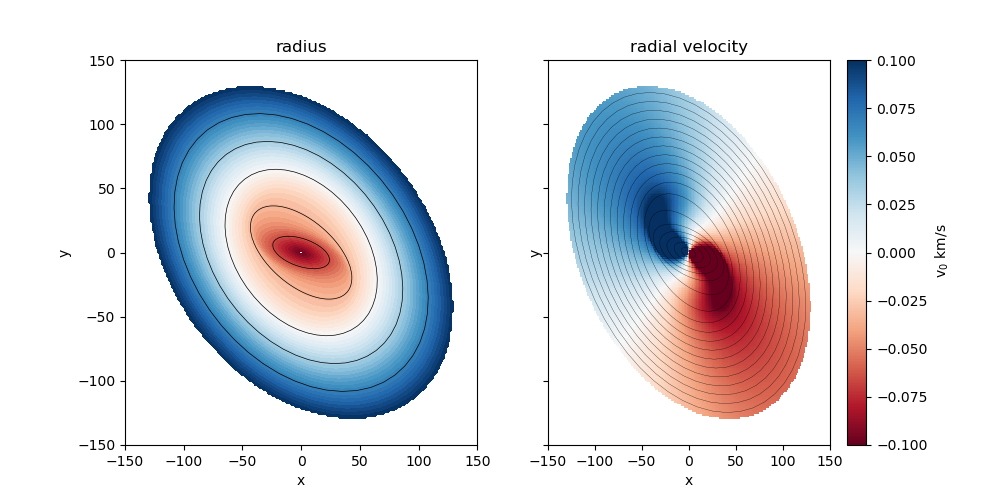

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
c1 = axs[0].contour(img_xc, img_yc, img_r, 5, colors='k', linewidths=.5)
c2 = axs[0].contourf(img_xc, img_yc, img_r, 50, cmap='RdBu')

vmin, vmax = np.percentile(img_v, [2, 98])
surf = axs[1].pcolormesh(img_xi, img_yi, img_v, cmap='RdBu', vmin=vmin, vmax=vmax)
axs[1].contour(img_xc, img_yc, img_r, 20, colors='k', linewidths=0.2)
fig.colorbar(surf, ax=axs[1], label=r' v$_{0}$ km/s')

axs[0].set_title('radius')
axs[1].set_title('radial velocity')

for ax in axs:
    ax.set_xlim(-150, 150)
    ax.set_ylim(-150, 150)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

In [36]:
#fig.savefig('warp.pdf', transparent=True, bbox_inches='tight')

## Pyvista

In [16]:
import pyvista as pv

vpoints = p1_c.reshape(-1, 3)
cloud = pv.PolyData(vpoints)
surf = cloud.delaunay_2d()

surf.save("surf.stl")

ModuleNotFoundError: No module named 'pyvista'